<a href="https://colab.research.google.com/github/UdayLab/PAMI/blob/main/notebooks/parallelFPGrowth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding frequent patterns in big transactional databases using Parallel FP-growth

This tutorial has two parts. In the first part, we describe the basic approach to find frequent patterns in a transactional database using the parallel FP-growth algorithm. In the final part, we describe an advanced approach, where we evaluate the algorithm on a dataset at different *minimum support* threshold values using 1 and 2 cores.

***

## Prerequisites:

1. Installing the PAMI library

In [1]:
!pip install 'pami[spark]' #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.5/796.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=166519d76dedb339d45165ff765b1074751e7139bd52621cf3fa031d23035946
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19580 sha256=8b7e7d04b00e81fdfb24331b195b9901fecadce946df693ada4100ac40be3dc5
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3310 sha256=95fcdc32cc72bc867ae5fd0179be5ade889b775b96566989f57cd

2. Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/transactionalDatabases/Transactional_T10I4D100K.csv #download a sample transactional database

--2023-07-28 06:24:42--  https://u-aizu.ac.jp/~udayrage/datasets/transactionalDatabases/Transactional_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.95.161.176, 150.31.244.160
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.95.161.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4019277 (3.8M) [text/csv]
Saving to: ‘Transactional_T10I4D100K.csv’

Transactional_T10I4 100%[===================>]   3.83M   986KB/s    in 4.0s    

2023-07-28 06:24:48 (986 KB/s) - ‘Transactional_T10I4D100K.csv’ saved [4019277/4019277]



3. Printing few lines of a dataset to know its format.

In [3]:
!head -2 Transactional_T10I4D100K.csv

25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
39	120	124	205	401	581	704	814	825	834


_format:_ every row contains items seperated by a seperator.

__Example:__

item1 item2 item3 item4

item1 item4 item6

***

## Part 1: Finding frequent patterns using parallel FP-growth

### Step 1: Understanding the statistics of a database to choose an appropriate *minimum support* (*minSup*) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.transactionalDatabaseStats as stats

#specify the file name
inputFile = 'Transactional_T10I4D100K.csv'

#initialize the class
obj=stats.transactionalDatabaseStats(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to derive the database statistics and plot the graphs
# obj.printStats()
# obj.plotGraphs()

Database size : 99935
Total number of items : 870
Database sparsity : 0.9883886940304302
Minimum Transaction Size : 1
Average Transaction Size : 10.101836193525791
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667097909135199
Variance in Transaction Sizes : 13.447741640067324


### Step 2: Draw the items' frequency graph and transaction length's distribution graphs for more information

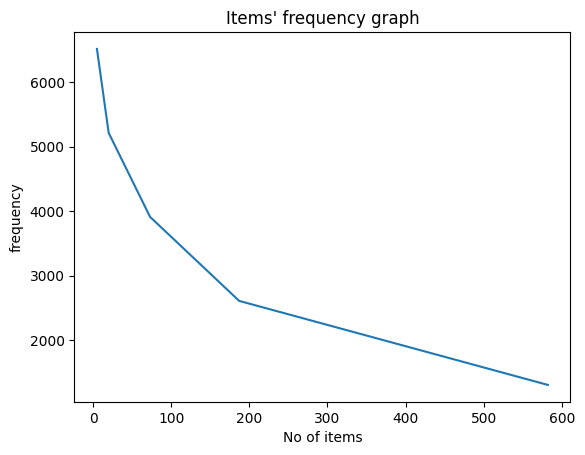

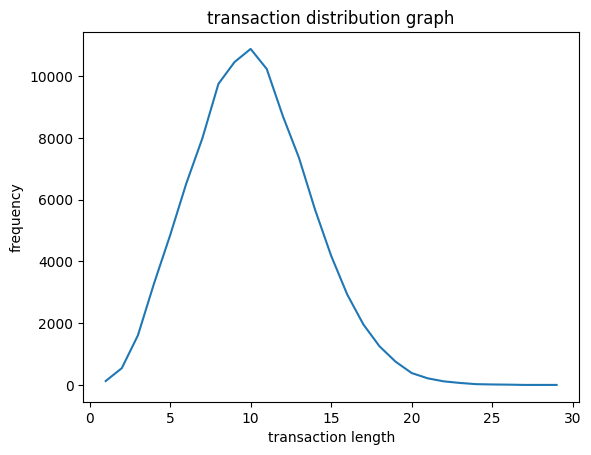

In [ ]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, 100, 'Items\' frequency graph', 'No of items', 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, 100, 'transaction distribution graph', 'transaction length', 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 300 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [ ]:
minSup=300 #minSup is specified in count. However, the users can also specify minSup between 0 and 1.

### Step 4: Choosing the number of worker machines

Let us choose the number of worker machines equal to 2

In [ ]:
noWorkerMachines=5

### Step 5: Mining frequent patterns using parallel FP-growth

In [ ]:
from PAMI.frequentPattern.pyspark import parallelFPGrowth as alg #import the algorithm

obj = alg.parallelFPGrowth(iFile=inputFile, minSup=minSup, numWorkers=noWorkerMachines, sep='\t')    #initialize
obj.startMine()            #start the mining process

obj.save('frequentPatternsAtMinSupCount300.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Total No of patterns: 4540
Runtime: 40.39675760269165
Memory (RSS): 171253760
Memory (USS): 123527168


### Step 6: Investigating the generated patterns

Open the patterns' file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [ ]:
!head frequentPatternsAtMinSupCount300.txt

368:7821 
529:7053 
829:6802 
766:6259 
722:5839 
354:5830 
684:5404 
217:5369 
494:5097 
419:5051 


The storage format is: _frequentPattern:support_



***

## Part 2: Evaluating the FP-growth algorithm on a dataset at different minSup values and worker machines

### Step 1: Import the libraries and specify the input parameters

In [5]:
#Import the libraries
from PAMI.frequentPattern.basic import FPGrowth  as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Transactional_T10I4D100K.csv'
seperator='\t'
minimumSupportCountList = [100, 150, 200, 250, 300]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

numWorkers = [1,2, 3, 4, 5]

### Step 2: Create a data frame to store the results of FP-growth

In [6]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of FPGrowth algorithm

### Step 3: Execute the algorithm at different minSup values

In [8]:
from PAMI.frequentPattern.pyspark import parallelFPGrowth as alg

for minSupCount in minimumSupportCountList:
  for workers in numWorkers:
    obj = alg.parallelFPGrowth(iFile=inputFile, minSup=minSupCount, numWorkers=workers, sep='\t')    #initialize
    obj.startMine()            #start the mining process
    result.loc[result.shape[0]] = [workers, minSupCount, len(obj.getPatterns()),obj.getRuntime(), obj.getMemoryRSS()]
    #obj.getMemoryRSS() is for future use when we can calculate the memory consumed by executors.

Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated success

### Step 4: Print the result

In [9]:
print(result)

    algorithm  minSup  patterns     runtime       memory
0         1.0   100.0   27517.0  200.431388  181813248.0
1         2.0   100.0   27517.0   58.722626  182530048.0
2         3.0   100.0   27517.0   67.208038  182751232.0
3         4.0   100.0   27517.0   71.262009  182751232.0
4         5.0   100.0   27517.0   75.050182  182751232.0
5         1.0   150.0   19119.0  215.779375  182751232.0
6         2.0   150.0   19119.0   51.575729  182751232.0
7         3.0   150.0   19119.0   59.140548  182902784.0
8         4.0   150.0   19119.0   61.538699  182902784.0
9         5.0   150.0   19119.0   62.497664  182902784.0
10        1.0   200.0   13252.0  188.679439  182902784.0
11        2.0   200.0   13252.0   45.932186  182902784.0
12        3.0   200.0   13252.0   53.030148  182906880.0
13        4.0   200.0   13252.0   53.883941  182906880.0
14        5.0   200.0   13252.0   58.521841  182906880.0
15        1.0   250.0    7679.0  168.944770  182906880.0
16        2.0   250.0    7679.0

### Step 5: Visualizing the results

In [16]:
import plotly.express as pe

pe.line(result, x='minSup', y='patterns', color='algorithm').show()
pe.line(result, x='minSup', y='runtime', color='algorithm').show()
#pe.line(result, x='minSup', y='memory', color='algorithm').show()
#Currently, we cannot calculate the memory consumed by a spark process in Python as it is carried out at multiple executors.

In [ ]:
from PAMI.extras.graph import dataFrameInToFigures as dif
ab = dif.dataFrameInToFigures(result)
ab.plotGraphsFromDataFrame()

ValueError: ignored